In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
pd.pandas.set_option('display.max_columns', None)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, r2_score, confusion_matrix, precision_score

In [2]:
data_set = pd.read_csv('Covid-19_Data.csv.csv')

C:\Users\sunil\.conda\envs\pil\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_set.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


# Data Preprocessing

In [4]:
data_set.drop('test_date', inplace=True, axis=1)

In [5]:
data_set['cough'].unique()

array([0, 1, '0', '1', 'None'], dtype=object)

In [6]:
data_set = data_set[data_set['cough']!='None']
data_set = data_set[data_set['fever']!='None']

In [7]:
data_set.replace(['1', '0'], [1, 0], inplace=True)

In [8]:
np.unique(data_set['corona_result'])

array(['negative', 'other', 'positive'], dtype=object)

In [9]:
# lets drop other columns and focus more on negative and positive results.
data_set = data_set[data_set['corona_result']!='other']

In [10]:
np.unique(data_set['corona_result'])

array(['negative', 'positive'], dtype=object)

In [11]:
data_set['corona_result'].replace(['negative', 'positive'], [0, 1], inplace=True)

In [12]:
np.unique(data_set['age_60_and_above'])
# lets drop None columns and focus more on No and Yes results.
data_set = data_set[data_set['age_60_and_above']!='None']

In [13]:
data_set['age_60_and_above'].replace(['No', 'Yes'], [0, 1], inplace=True)

In [14]:
np.unique(data_set['gender'])
data_set = data_set[data_set['gender']!='None']

In [15]:
data_set['gender'].replace(['female', 'male'], [0, 1], inplace=True)

In [16]:
np.unique(data_set['test_indication'])

array(['Abroad', 'Contact with confirmed', 'Other'], dtype=object)

In [17]:
dummies = pd.get_dummies(data_set['test_indication'])
data_set.drop('test_indication', inplace=True, axis=1)
data_set = pd.concat([data_set, dummies], axis=1)

In [18]:
data_set.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,Abroad,Contact with confirmed,Other
122808,1,0,0,0,0,0,1,1,0,0,1
122809,1,0,0,0,0,1,0,0,0,0,1
122810,0,0,0,0,0,0,0,0,0,0,1
122811,0,1,0,0,0,0,0,0,1,0,0
122812,1,0,0,0,0,0,1,0,0,0,1


# Data Visualization

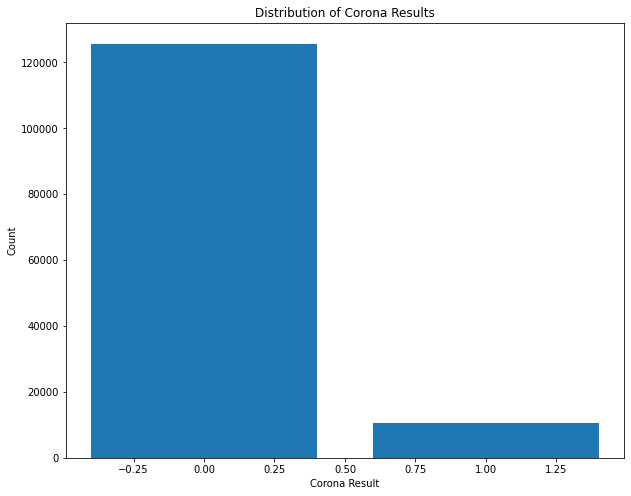

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(data_set['corona_result'].unique(), data_set['corona_result'].value_counts())
ax.set_xlabel('Corona Result')
ax.set_ylabel('Count')
ax.set_title('Distribution of Corona Results')
plt.show()

In [20]:
feature_count = []
for unique_characteristic in data_set:
    col_sum = sum(data_set[unique_characteristic].values)
    feature_count.append(col_sum)

In [21]:
feature_count = [sum(data_set[unique_characteristic].values) for unique_characteristic in data_set]

In [22]:
feature_count

[24851, 12661, 1473, 1061, 2075, 10626, 23701, 69153, 14534, 7402, 114358]

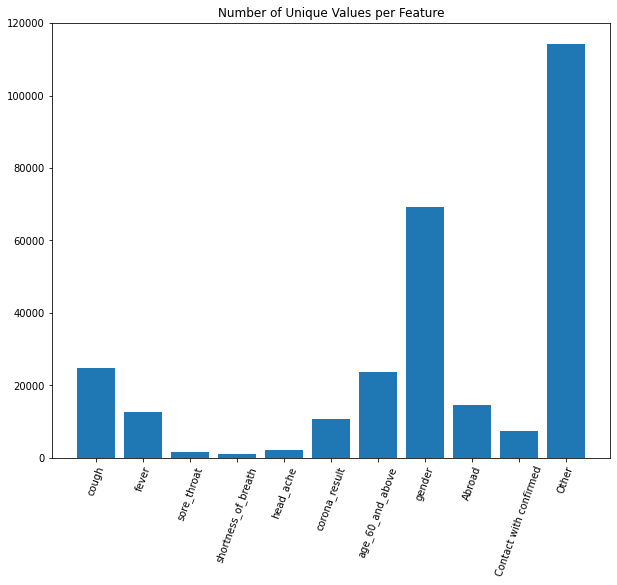

In [23]:
#feature_count = data_set.nunique()

# create a bar plot using Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(data_set.columns, feature_count)
ax.set_xlabel('Feature')
ax.set_ylabel('Count')
ax.set_title('Number of Unique Values per Feature')

# add text annotations to the bars
# rotate x-axis tick labels
plt.xticks(rotation=70)

plt.show()

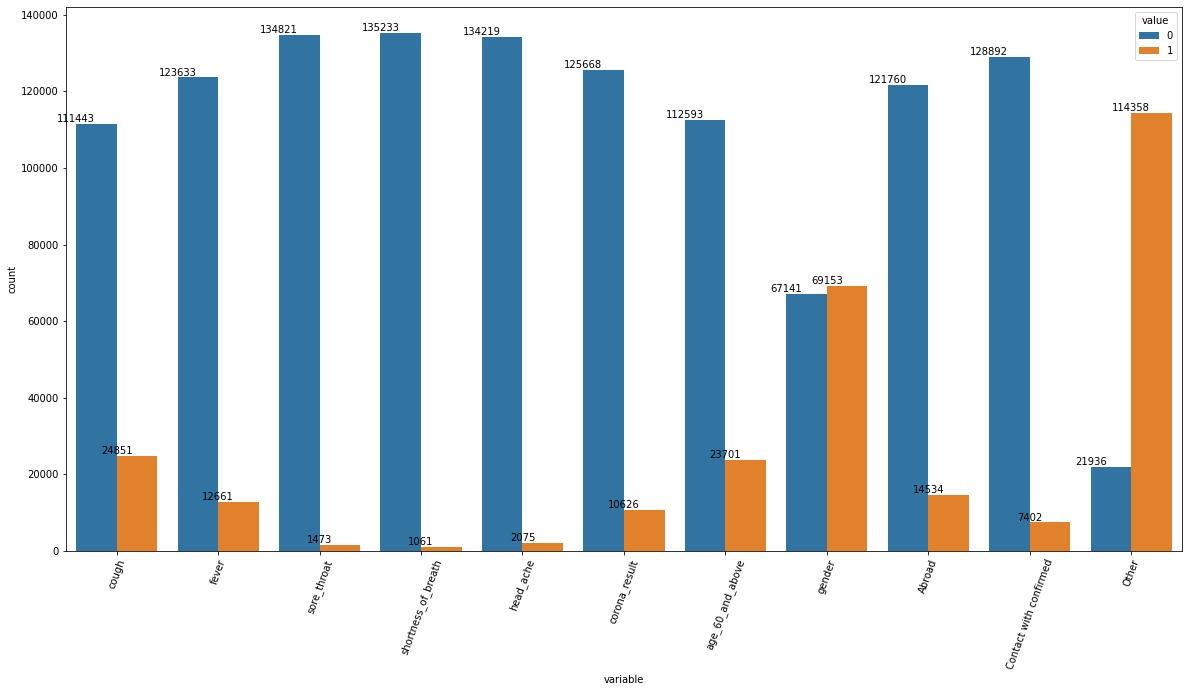

In [24]:
plt.figure(figsize = (20 ,10))
count_plots = sns.countplot(x="variable", hue="value", data=pd.melt(data_set))
plt.setp(count_plots.get_xticklabels(), rotation=70)
for p in count_plots.patches:
        count_plots.annotate(int(p.get_height()), (p.get_x(), p.get_height()+500), horizontalalignment = "center")
plt.show()

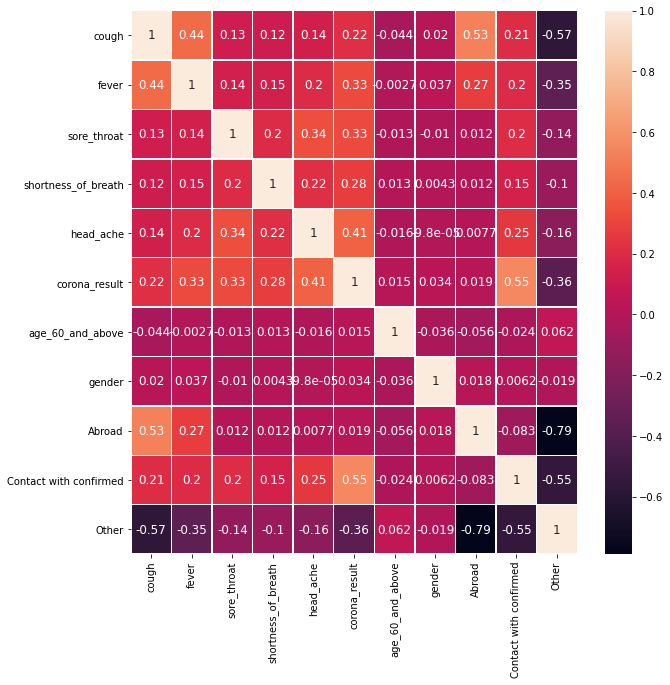

In [25]:
sns.heatmap(data_set.corr(),annot=True,linewidths=0.4, annot_kws={"size": 12}) 
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

# Model Training

In [26]:
data_set.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,Abroad,Contact with confirmed,Other
count,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000,136294.000000
mean,0.182334,0.092895,0.010808,0.007785,0.015224,0.077964,0.173896,0.507381,0.106637,0.054309,0.839054
std,0.386121,0.290286,0.103396,0.087887,0.122445,0.268116,0.379022,0.499947,0.308652,0.226627,0.367483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
data_set.isnull().sum()

cough                     0
fever                     0
sore_throat               0
shortness_of_breath       0
head_ache                 0
corona_result             0
age_60_and_above          0
gender                    0
Abroad                    0
Contact with confirmed    0
Other                     0
dtype: int64

In [28]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136294 entries, 122808 to 265120
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   cough                   136294 non-null  int64
 1   fever                   136294 non-null  int64
 2   sore_throat             136294 non-null  int64
 3   shortness_of_breath     136294 non-null  int64
 4   head_ache               136294 non-null  int64
 5   corona_result           136294 non-null  int64
 6   age_60_and_above        136294 non-null  int64
 7   gender                  136294 non-null  int64
 8   Abroad                  136294 non-null  uint8
 9   Contact with confirmed  136294 non-null  uint8
 10  Other                   136294 non-null  uint8
dtypes: int64(8), uint8(3)
memory usage: 9.7 MB


In [29]:
y = data_set['corona_result']

In [30]:
data_set.drop('corona_result', axis=1, inplace=True)

In [31]:
time_taken = list()

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_set, y, test_size=0.3, random_state=123, stratify=y)
start = time.time()
print("X_train Shape : ", X_train.shape) 
print("X_test Shape : ", X_test.shape) 
print("y_train Shape : ", y_train.shape) 
print("y_test Shape : ", y_test.shape)

# DecisionTree Algorithm
DecisionTree = DecisionTreeClassifier(random_state=0) 
scores = cross_val_score(DecisionTree, data_set, y, cv=5) 


print('DecisionTree scores.mean: ', scores.mean()) 
DecisionTree = DecisionTree.fit(X_train, y_train) 
decission_pred = DecisionTree.predict(X_test) 
print('DecisionTree r2_score: ', r2_score(y_test, decission_pred)) 
end = time.time()
time_taken.append(end-start)

X_train Shape :  (95405, 10)
X_test Shape :  (40889, 10)
y_train Shape :  (95405,)
y_test Shape :  (40889,)
DecisionTree scores.mean:  0.9579512325481468
DecisionTree r2_score:  0.41485465591589266


# Hyper-parameter tunning

In [33]:
# Parameter tuning to maximum depth to increase accuracy

In [34]:
training_accuracy = list()
validation_accuracy = list()
for max_d in range(1,10):
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(X_train, y_train)
    training_accuracy.append(DecisionTree.score(X_train, y_train))
    validation_accuracy.append(DecisionTree.score(X_test,y_test))
    print('The Training Accuracy for max_depth {} is:'.format(max_d), DecisionTree.score(X_train, y_train))
    print('The Validation Accuracy for max_depth {} is:'.format(max_d), DecisionTree.score(X_test,y_test))
    print('')

The Training Accuracy for max_depth 1 is: 0.9582831088517373
The Validation Accuracy for max_depth 1 is: 0.957934896916041

The Training Accuracy for max_depth 2 is: 0.9582831088517373
The Validation Accuracy for max_depth 2 is: 0.957934896916041

The Training Accuracy for max_depth 3 is: 0.9582831088517373
The Validation Accuracy for max_depth 3 is: 0.957934896916041

The Training Accuracy for max_depth 4 is: 0.9582831088517373
The Validation Accuracy for max_depth 4 is: 0.957934896916041

The Training Accuracy for max_depth 5 is: 0.9582831088517373
The Validation Accuracy for max_depth 5 is: 0.957934896916041

The Training Accuracy for max_depth 6 is: 0.9582831088517373
The Validation Accuracy for max_depth 6 is: 0.957934896916041

The Training Accuracy for max_depth 7 is: 0.9582831088517373
The Validation Accuracy for max_depth 7 is: 0.957934896916041

The Training Accuracy for max_depth 8 is: 0.9582831088517373
The Validation Accuracy for max_depth 8 is: 0.957934896916041

The Trai

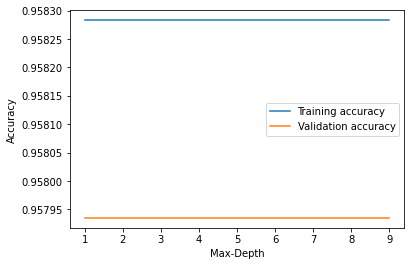

In [35]:
plt.plot(list(range(1,10)), training_accuracy )
plt.plot(list(range(1,10)), validation_accuracy)
plt.xlabel('Max-Depth')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Taking any depth would result in same accuracy.

In [36]:
training_accuracy = list()
validation_accuracy = list()
for max_f in range(2,10):
    model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes= max_f , random_state=42)
    model.fit(X_train, y_train)
    training_accuracy.append(DecisionTree.score(X_train, y_train))
    validation_accuracy.append(DecisionTree.score(X_test,y_test))
    print('The Training Accuracy for max_leaf_nodes {} is:'.format(max_f), DecisionTree.score(X_train, y_train))
    print('The Validation Accuracy for max_leaf_nodes {} is:'.format(max_f), DecisionTree.score(X_test,y_test))
    print('')

The Training Accuracy for max_leaf_nodes 2 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 2 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 3 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 3 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 4 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 4 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 5 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 5 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 6 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 6 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 7 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 7 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 8 is: 0.9582831088517373
The Validation Accuracy for max_leaf_nodes 8 is: 0.957934896916041

The Training Accuracy for max_leaf_nodes 9 is: 0.9582831088517

In [37]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [38]:
param_dist = {"max_depth": list(range(1,8)),
             "max_features": randint(0,8),
             "min_samples_leaf": randint(1,8),
             "criterion": ["gini", 'entropy']}
tree_cv = RandomizedSearchCV(DecisionTree, param_dist, cv=5)

In [39]:
tree_cv.fit(data_set, y)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028D0B211978>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028D0AA0C390>})

In [40]:
tree_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 6,
 'min_samples_leaf': 5}

In [41]:
previous_score = tree_cv.best_score_

In [42]:
# lets drop negatively effecting columns 
data_set.corr()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,Abroad,Contact with confirmed,Other
cough,1.000000,0.444898,0.125416,0.116872,0.135117,-0.044193,0.020147,0.526316,0.209147,-0.571040
fever,0.444898,1.000000,0.143779,0.145360,0.200694,-0.002714,0.037465,0.274075,0.198677,-0.352723
sore_throat,0.125416,0.143779,1.000000,0.200670,0.337043,-0.013321,-0.009988,0.011708,0.204154,-0.135736
shortness_of_breath,0.116872,0.145360,0.200670,1.000000,0.218756,0.013325,0.004286,0.012133,0.148594,-0.101829
head_ache,0.135117,0.200694,0.337043,0.218756,1.000000,-0.016100,-0.000098,0.007713,0.252326,-0.162088
age_60_and_above,-0.044193,-0.002714,-0.013321,0.013325,-0.016100,1.000000,-0.035756,-0.056221,-0.024359,0.062243
gender,0.020147,0.037465,-0.009988,0.004286,-0.000098,-0.035756,1.000000,0.017770,0.006176,-0.018734
Abroad,0.526316,0.274075,0.011708,0.012133,0.007713,-0.056221,0.017770,1.000000,-0.082795,-0.788851
Contact with confirmed,0.209147,0.198677,0.204154,0.148594,0.252326,-0.024359,0.006176,-0.082795,1.000000,-0.547162
Other,-0.571040,-0.352723,-0.135736,-0.101829,-0.162088,0.062243,-0.018734,-0.788851,-0.547162,1.000000


In [43]:
data_set.drop('Other', axis=1, inplace=True)

In [44]:
tree_cv = RandomizedSearchCV(DecisionTree, param_dist, cv=5)
tree_cv.fit(data_set, y)

C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\tree\_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\tree\_classes.py", line 289, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The

C:\Users\sunil\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.93385631        nan 0.95088564 0.93607206 0.94932285 0.95535391
 0.94784808 0.94153086 0.95686534        nan]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028D0B211978>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028D0AA0C390>})

In [45]:
current_score = tree_cv.best_score_

In [46]:
print(current_score, previous_score)

0.9568653405426332 0.9559335403554791


<BarContainer object of 2 artists>

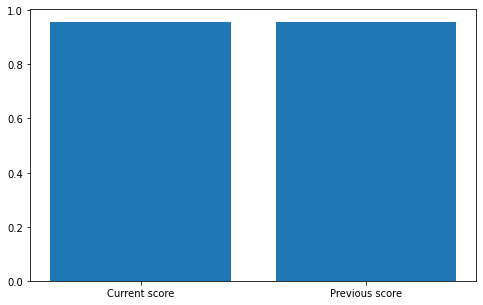

In [47]:
plt.figure(figsize=(8,5))
plt.bar(['Current score', 'Previous score'], [current_score, previous_score])

### The decision tree model has reached a point where further parameter tuning does not improve its accuracy. To improve the accuracy of the model, we need to either add more relevant features to the dataset or increase the number of unique records to make the dataset more robust.

# Logistic Regression

In [48]:
start = time.time()
print("X_train Shape : ", X_train.shape) 
print("X_test Shape : ", X_test.shape) 
print("y_train Shape : ", y_train.shape) 
print("y_test Shape : ", y_test.shape)
log = LogisticRegression()
scores = cross_val_score(log, data_set, y, cv=5) 
print('LogisticRegression scores.mean: ', scores.mean()) 
log.fit(X_train, y_train) 
pred = log.predict(X_test) 
print('LogisticRegression r2_score: ', r2_score(y_test, pred))
log_score = scores.mean()
end = time.time()
print("\n"+ str(end-start))
time_taken.append(end-start)

X_train Shape :  (95405, 10)
X_test Shape :  (40889, 10)
y_train Shape :  (95405,)
y_test Shape :  (40889,)
LogisticRegression scores.mean:  0.9506875668178327
LogisticRegression r2_score:  0.33967028321671366

3.309509038925171


# K Nearest Neigbhours

In [49]:
start = time.time()
print("X_train Shape : ", X_train.shape) 
print("X_test Shape : ", X_test.shape) 
print("y_train Shape : ", y_train.shape) 
print("y_test Shape : ", y_test.shape)
Knn = KNeighborsClassifier()
scores = cross_val_score(Knn, data_set, y, cv=5) 
print('KNeighborsClassifier scores.mean: ', scores.mean()) 
Knn.fit(X_train, y_train) 
pred = Knn.predict(X_test) 
print('KNeighborsClassifier r2_score: ', r2_score(y_test, pred))
knn_score = scores.mean()
end = time.time()
print("\n"+ str(end-start))
time_taken.append(end-start)

X_train Shape :  (95405, 10)
X_test Shape :  (40889, 10)
y_train Shape :  (95405,)
y_test Shape :  (40889,)
KNeighborsClassifier scores.mean:  0.9518541257372345
KNeighborsClassifier r2_score:  0.3651853418250324

591.8124899864197


# Support Vector Classifier

In [50]:
start = time.time()
print("X_train Shape : ", X_train.shape) 
print("X_test Shape : ", X_test.shape) 
print("y_train Shape : ", y_train.shape) 
print("y_test Shape : ", y_test.shape)
svc = SVC()
scores = cross_val_score(svc, data_set, y, cv=5) 
print('SVC scores.mean: ', scores.mean()) 
svc.fit(X_train, y_train) 
pred = svc.predict(X_test) 
print('SVC r2_score: ', r2_score(y_test, pred))
svc_score = scores.mean()
end = time.time()
print("\n"+ str(end - start))
time_taken.append(end-start)

X_train Shape :  (95405, 10)
X_test Shape :  (40889, 10)
y_train Shape :  (95405,)
y_test Shape :  (40889,)
SVC scores.mean:  0.9580466190043124
SVC r2_score:  0.41859686451177935

1236.0940997600555


# VotingClassifier

In [51]:
vot_clf = VotingClassifier(estimators=[('tree', DecisionTree), ('log', log), ('knn', Knn), ('SVC', svc)], voting='hard')
vot_clf.fit(data_set, y)

VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=0)),
                             ('log', LogisticRegression()),
                             ('knn', KNeighborsClassifier()), ('SVC', SVC())])

In [52]:
vot_pred = vot_clf.predict(data_set)

In [53]:
vot_clf.score(data_set, y)

0.958237339868226

C:\Users\sunil\.conda\envs\pil\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


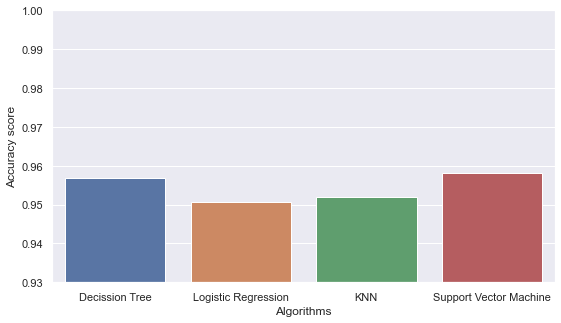

In [54]:
with sns.color_palette('muted'):
    algothrim_name = ['Decission Tree', 'Logistic Regression', 'KNN', 'Support Vector Machine']
    scores = [current_score, log_score, knn_score, svc_score]
    sns.set(rc={'figure.figsize':(9,5)})
    plt.xlabel("Algorithms")
    plt.ylabel("Accuracy score")
    plt.ylim(0.93, 1)
    sns.barplot(algothrim_name, scores)

C:\Users\sunil\.conda\envs\pil\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


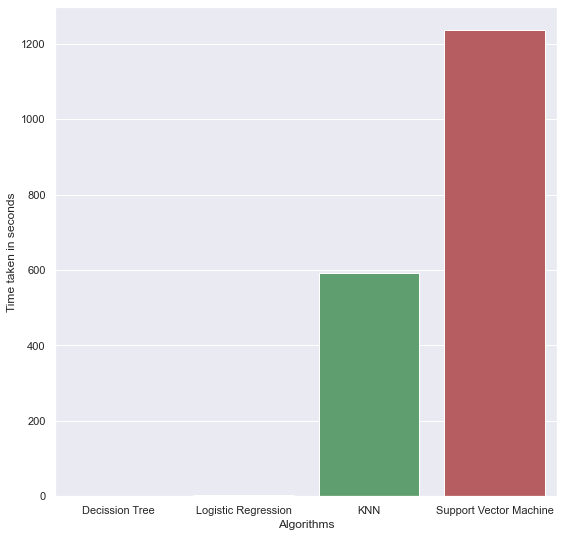

In [55]:
with sns.color_palette('muted'):
    algothrim_name = ['Decission Tree', 'Logistic Regression', 'KNN', 'Support Vector Machine']
    sns.set(rc={'figure.figsize':(9,9)})
    plt.xlabel("Algorithms")
    plt.ylabel("Time taken in seconds")
    sns.barplot(algothrim_name, time_taken)

# Evaluation metrics

In [56]:
# lets consider Decision-tree beccause the time complexity and accuracy is more for that algorithm

#### Confusion matrix

In [57]:
con_mat = confusion_matrix(y_test, decission_pred)

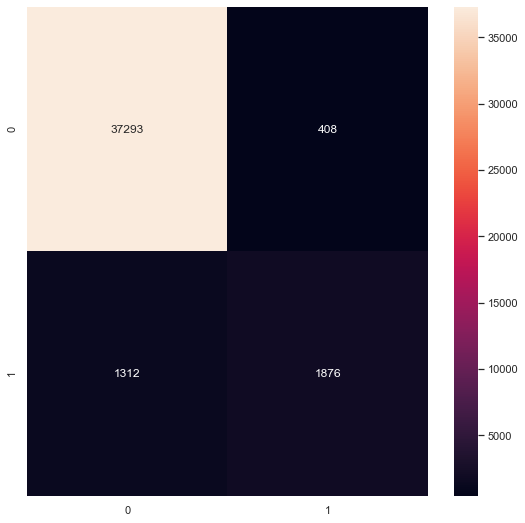

In [69]:
matrix = sns.heatmap(con_mat, annot=True, fmt='.8g')

<p>{0,0} False Negative <br>
{0,1} False Positive <br>
{1,0} True Negative <br>
{1,1} True Positive <br>
</p>

In [59]:
accuracy_score(decission_pred, y_test)

0.957934896916041

In this example, the accuracy is nearly 95%; approximately 3.2 percent of records with Covid-19 are classed as healthy. By using this example, we are attempting to demonstrate that accuracy is not a good metric when the data set is uneven. In such cases, using accuracy might lead to a false interpretation of the findings.

We'll now look for accuracy (positive predictive value) in identifying data instances. The following is how precision is defined:

In [60]:
precision_score(y_test, decission_pred)

0.8213660245183888

As a result, if FN approaches zero, the recal rate approaches one, indicating that the model is doing well.

In [61]:
recall_score(y_test, decission_pred)

0.588456712672522

Only when accuracy and recall are both 1 does the F1 Score become 1. Only when both accuracy and recall are good can the F1 score rise. The F1 score is a better metric than accuracy since it is the harmonic mean of precision and recall.

In [62]:
f1_score(y_test, decission_pred)

0.6856725146198831

# Feature Importance

In [70]:
random_forest = RandomForestClassifier()
random_forest.fit(data_set, y)
start_time = time.time()
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Time taken to calculate the importances: {elapsed_time:.3f} seconds")

Time taken to calculate the importances: 0.014 seconds


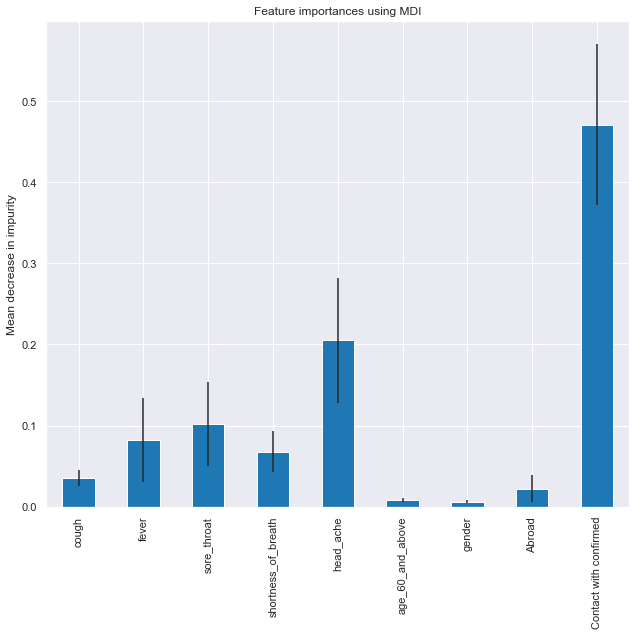

In [64]:
forest_importances = pd.Series(importances, index=data_set.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [65]:
start_time = time.time()
result = permutation_importance(
    random_forest, data_set, y, n_repeats=5, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=data_set.columns)

Elapsed time to compute the importances: 37.539 seconds


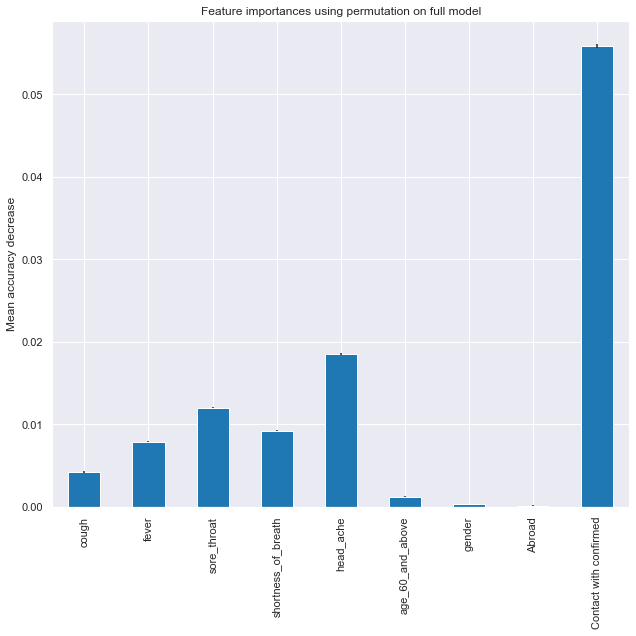

In [66]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Observation reveals that traits such as `Contact With Confirmed`, `Headache`, and `Sore Throat` are more relevant than others.

# CONCLUSION 
The final objective is to create a machine learning model that effectively predicts COVID-19 using fewer features and tests. The study focuses on only nine key features and uses four distinct classification techniques, including support vector machine, K closest neighbors, logistic regression, and decision tree. The data was pre-processed before being utilized in the model. Among the strategies employed, support vector machine and decision trees yielded the best outcomes, with decision trees being preferable due to their lower time complexity. To improve accuracy, other methodologies such as clustering, association rules, and genetic algorithms could be utilized. However, given the limitations of this study, more complex and combined models are necessary to achieve greater accuracy in early COVID-19 prediction.

# REFERENCES
-  Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real 
time. The Lancet Infectious Diseases. Published online February 19, 2020. doi:10.1016/S1473-
3099(20)30120-1
-  Gozes O, Frid-Adar M, Greenspan H, et al. Rapid AI Development Cycle for the Coronavirus 
(COVID-19) Pandemic: Initial Results for Automated Detection & Patient Monitoring using 
Deep Learning CT Image Analysis. arXiv e-prints. 2020;2003:arXiv:2003.05037. Accessed May 
4, 2020. http://adsabs.harvard.edu/abs/2020arXiv200305037G
- Dataset taken from :https://github.com/nshomron/covidpred/tree/master/data
- Feature importance reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
- Dataset for further resarch: https://www.kaggle.com/datasets/imdevskp/corona-virus-report